<a href="https://colab.research.google.com/github/SeungwonMJ/MyCodes/blob/main/Final_Project_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, BayesianRidge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR
from transformers import DistilBertModel, DistilBertTokenizer
import matplotlib.pyplot as plt
import torch

# With Text Embeddings

## Preprocessing for Text Embeddings

In [ ]:
df = pd.read_csv("vgsales.csv").dropna()
model_name = "distilbert-base-multilingual-cased"
device = torch.device('cuda')
model = DistilBertModel.from_pretrained(model_name)
model.to(device)
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
embeddings = list()
for i in range(0, len(df), 1000):
  upper_bound = min(i + 1000, len(df))
  tokenized_batch = tokenizer(list(df['Name'][i:upper_bound]), return_tensors='pt', padding=True, truncation=True)
  for k,v in tokenized_batch.items():
      tokenized_batch[k] = v.to(device)
  with torch.no_grad():
    outputs = model(**tokenized_batch)
  embeddings.append(outputs.last_hidden_state.mean(dim=1).cpu().numpy())
  print((i / 1000) + 1)
  del(tokenized_batch)
  del(outputs)


config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0


## Text Embedding Converstion and Full Preprocessing

In [ ]:
embeds = np.concatenate(embeddings, axis = 0)
pca = PCA(n_components = 100)
embeds_pca = pca.fit_transform(embeds)
embeds_df = pd.DataFrame(embeds_pca, columns = [f"embedding_{i}" for i in range(100)])

In [ ]:
# Feature selection
X = df[['Rank', 'Platform', 'Year', 'Genre', 'Publisher', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']]
y = df['Global_Sales']

# Normalize sales columns using .loc to avoid SettingWithCopyWarning
for sales in ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']:
    X.loc[:, sales] /= df["Global_Sales"]

# Replace less frequent publishers with 'Other' using .loc
publishers = set(X['Publisher'].value_counts()[:5].index)
X.loc[:, 'Publisher'] = X['Publisher'].apply(lambda x: x if x in publishers else 'Other')
# One-hot encode categorical columns
X = pd.get_dummies(X, columns=['Platform', 'Publisher', 'Genre'])
X = X.assign(**embeds_df)
mask = X.isna().sum(axis=1) == 0
X = X.loc[mask]
y = y.loc[mask]
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

<ipython-input-124-77ec7b821f56>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:, sales] /= df["Global_Sales"]
<ipython-input-124-77ec7b821f56>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:, 'Publisher'] = X['Publisher'].apply(lambda x: x if x in publishers else 'Other')
<ipython-input-124-77ec7b821f56>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at onc

## Model Creation, Training, and Assessment

In [ ]:
# Use different regression models
en_model = ElasticNet(alpha=0.011, l1_ratio = 0.2)
br_model = BayesianRidge(alpha_1=1e-4, alpha_2=1e-6, lambda_1=1e-6, lambda_2=1e-4)
boost_model = GradientBoostingRegressor(n_estimators = 100, max_depth = 30, min_samples_leaf = 2, learning_rate = 0.1)  # Polynomial features will be added later
rf_model = RandomForestRegressor(max_depth = 30, min_samples_leaf = 2, n_estimators=100, random_state=42)
nn_model = MLPRegressor(hidden_layer_sizes=(100,100, 100, 100, 100), max_iter=500, random_state=42)
dt_model = DecisionTreeRegressor(max_depth = 30, min_samples_leaf = 2)
# Create an ensemble of models
models_to_ensemble = [en_model, br_model, boost_model, rf_model, nn_model, dt_model]
# Train and evaluate the ensemble of models
predictions = []
ensemble_model = LinearRegression()
test_predictions = []
for model in models_to_ensemble:
    # Feature scaling for numerical features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    # Model training
    model.fit(X_train_scaled, y_train)
    predictions.append(model.predict(X_train_scaled))
    # Model evaluation
    y_pred = model.predict(X_test_scaled)
    test_predictions.append(y_pred)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"{model.__class__.__name__} Model Evaluation:")
    print("Mean Squared Error:", mse)
    print("Mean Absolute Error:", mae)
    print("R2 Score:", r2)
predictions = np.asarray(predictions).T
test_predictions = np.asarray(test_predictions).T
# Ensemble predictions using the average
ensemble_model.fit(predictions, y_train)
ensemble_prediction = ensemble_model.predict(test_predictions)
# Ensemble model evaluation
ensemble_mse = mean_squared_error(y_test, ensemble_prediction)
ensemble_mae = mean_absolute_error(y_test, ensemble_prediction)
ensemble_r2 = r2_score(y_test, ensemble_prediction)

print("Ensemble Model Evaluation:")
print("Mean Squared Error:", ensemble_mse)
print("Mean Absolute Error:", ensemble_mae)
print("R2 Score:", ensemble_r2)

(11195, 155)
ElasticNet Model Evaluation:
Mean Squared Error: 2.7360218776327425
Mean Absolute Error: 0.5345532084087575
R2 Score: 0.18972508744878158
(11195, 155)
BayesianRidge Model Evaluation:
Mean Squared Error: 2.7381433624640557
Mean Absolute Error: 0.5342968475681504
R2 Score: 0.18909680813923957
(11195, 155)
GradientBoostingRegressor Model Evaluation:
Mean Squared Error: 0.4737280808461656
Mean Absolute Error: 0.014275132253308783
R2 Score: 0.8597050767690507
(11195, 155)
RandomForestRegressor Model Evaluation:
Mean Squared Error: 0.5597834185054139
Mean Absolute Error: 0.01431209262953505
R2 Score: 0.8342197245624582
(11195, 155)
MLPRegressor Model Evaluation:
Mean Squared Error: 1.806974266814618
Mean Absolute Error: 0.24856386791536553
R2 Score: 0.46486322788751844
(11195, 155)
DecisionTreeRegressor Model Evaluation:
Mean Squared Error: 0.42103079002825244
Mean Absolute Error: 0.013899194108656648
R2 Score: 0.8753114186109203
Ensemble Model Evaluation:
Mean Squared Error: 0.

# Without Text Embeddings

## Preprocessing

In [ ]:
# Feature selection
df = pd.read_csv("vgsales.csv").dropna()
X = df[['Rank', 'Platform', 'Year', 'Genre', 'Publisher', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']]
y = df['Global_Sales']

# Normalize sales columns using .loc to avoid SettingWithCopyWarning
for sales in ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']:
    X.loc[:, sales] /= df["Global_Sales"]

# Replace less frequent publishers with 'Other' using .loc
publishers = set(X['Publisher'].value_counts()[:5].index)
X.loc[:, 'Publisher'] = X['Publisher'].apply(lambda x: x if x in publishers else 'Other')
# One-hot encode categorical columns
X = pd.get_dummies(X, columns=['Platform', 'Publisher', 'Genre'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

<ipython-input-5-d4f8cb10f589>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:, sales] /= df["Global_Sales"]
<ipython-input-5-d4f8cb10f589>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:, 'Publisher'] = X['Publisher'].apply(lambda x: x if x in publishers else 'Other')


## Model Creation, Training and Assessment

In [ ]:
# Use different regression models
en_model = ElasticNet(alpha=0.011, l1_ratio = 0.2)
br_model = BayesianRidge(alpha_1=1e-4, alpha_2=1e-6, lambda_1=1e-6, lambda_2=1e-4)
boost_model = GradientBoostingRegressor(n_estimators = 100, max_depth = 30, min_samples_leaf = 2, learning_rate = 0.1)  # Polynomial features will be added later
rf_model = RandomForestRegressor(max_depth = 30, min_samples_leaf = 2, n_estimators=100, random_state=42)
nn_model = MLPRegressor(hidden_layer_sizes=(100,100, 100, 100, 100), max_iter=500, random_state=42)
dt_model = DecisionTreeRegressor(max_depth = 30, min_samples_leaf = 2)
# Create an ensemble of models
models_to_ensemble = [en_model, br_model, boost_model, rf_model, nn_model, dt_model]
# Train and evaluate the ensemble of models
predictions = []
ensemble_model = LinearRegression()
test_predictions = []
results_data = {'mse': {}, 'mae': {}, 'r2': {}}
for model in models_to_ensemble:
    # Feature scaling for numerical features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    # Model training
    model.fit(X_train_scaled, y_train)
    predictions.append(model.predict(X_train_scaled))
    # Model evaluation
    y_pred = model.predict(X_test_scaled)
    test_predictions.append(y_pred)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results_data['mse'][model.__class__.__name__] = mse
    results_data['mae'][model.__class__.__name__] = mae
    results_data['r2'][model.__class__.__name__] = r2
    print(f"{model.__class__.__name__} Model Evaluation:")
    print("Mean Squared Error:", mse)
    print("Mean Absolute Error:", mae)
    print("R2 Score:", r2)
predictions = np.asarray(predictions).T
test_predictions = np.asarray(test_predictions).T
# Ensemble predictions using the average
ensemble_model.fit(predictions, y_train)
ensemble_prediction = ensemble_model.predict(test_predictions)
# Ensemble model evaluation
ensemble_mse = mean_squared_error(y_test, ensemble_prediction)
ensemble_mae = mean_absolute_error(y_test, ensemble_prediction)
ensemble_r2 = r2_score(y_test, ensemble_prediction)

print("Ensemble Model Evaluation:")
print("Mean Squared Error:", ensemble_mse)
print("Mean Absolute Error:", ensemble_mae)
print("R2 Score:", ensemble_r2)

ElasticNet Model Evaluation:
Mean Squared Error: 2.8563032425258
Mean Absolute Error: 0.5029700683342729
R2 Score: 0.1466814864781233
BayesianRidge Model Evaluation:
Mean Squared Error: 2.8562118723480623
Mean Absolute Error: 0.5038097804892991
R2 Score: 0.1467087832521795
GradientBoostingRegressor Model Evaluation:
Mean Squared Error: 0.43374982804566964
Mean Absolute Error: 0.012637522089188035
R2 Score: 0.8704175547617973
RandomForestRegressor Model Evaluation:
Mean Squared Error: 0.48432902543754197
Mean Absolute Error: 0.012038743167294001
R2 Score: 0.8553070563766902
MLPRegressor Model Evaluation:
Mean Squared Error: 1.6177259416189493
Mean Absolute Error: 0.21453541786182762
R2 Score: 0.5167055530954917
DecisionTreeRegressor Model Evaluation:
Mean Squared Error: 0.4156756239770867
Mean Absolute Error: 0.012831423895253938
R2 Score: 0.8758172100642418
Ensemble Model Evaluation:
Mean Squared Error: 0.43627252784539605
Mean Absolute Error: 0.012690573950600616
R2 Score: 0.869663900

## Plot results without Text Embeddings

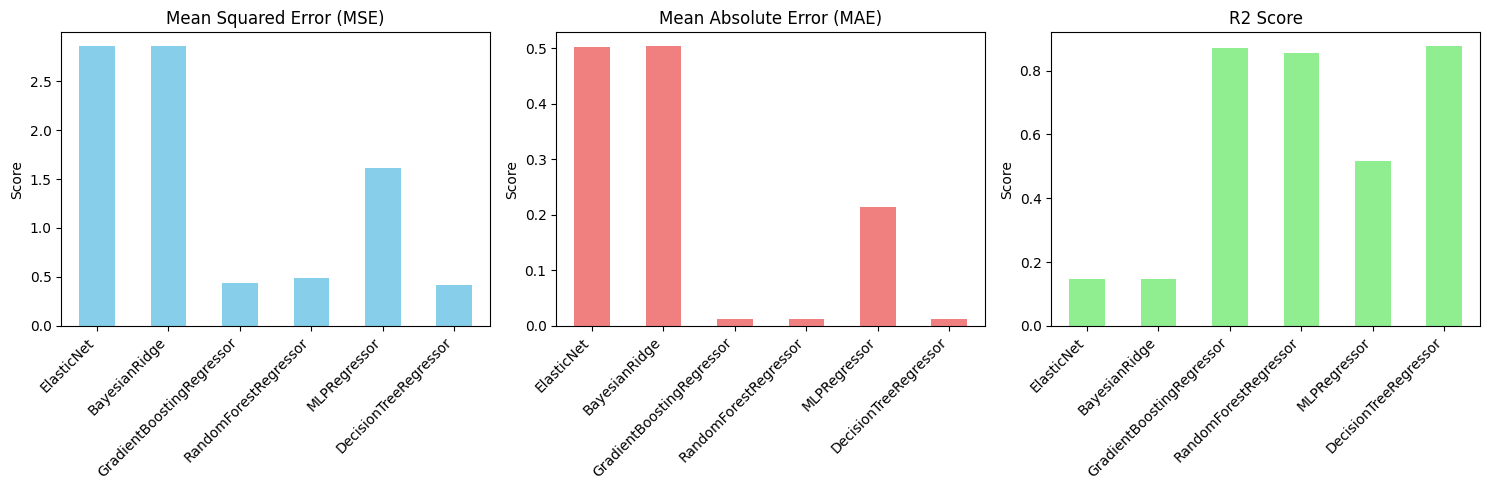

In [ ]:

results = pd.DataFrame(results_data).reset_index()
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Bar chart for MSE
results['mse'].plot(kind='bar', ax=axs[0], color='skyblue')
axs[0].set_title('Mean Squared Error (MSE)')
axs[0].set_ylabel('Score')

# Bar chart for MAE
results['mae'].plot(kind='bar', ax=axs[1], color='lightcoral')
axs[1].set_title('Mean Absolute Error (MAE)')
axs[1].set_ylabel('Score')

# Bar chart for R2
results['r2'].plot(kind='bar', ax=axs[2], color='lightgreen')
axs[2].set_title('R2 Score')
axs[2].set_ylabel('Score')

# Set x labels
for ax in axs:
    ax.set_xticklabels(results['index'], rotation=45, ha='right')

plt.tight_layout()
plt.show()